# Visualizing Regression Uncertainty

In this notebook we visualize regression uncertainties for subspace inference.

In [6]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data
from torch.nn import functional as F

from visualization import plot_predictive
import seaborn as sns

import subspace_inference.utils as utils
from subspace_inference.posteriors import SWAG
from subspace_inference import models, losses, utils
from subspace_inference.models import MLP
from tqdm import tqdm

import os

torch.backends.cudnn.benchmark = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

%load_ext autoreload
%autoreload 2

## Data and Model
Let's load the dataset we used in the paper. 

Text(0.5, 1.0, 'Data')

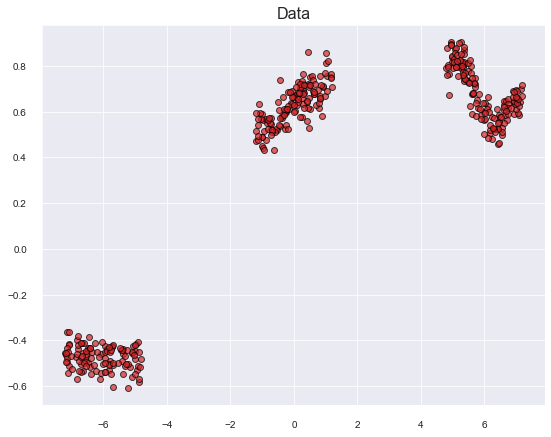

In [7]:
def features(x):
    return np.hstack([x[:, None] / 2.0, (x[:, None] / 2.0) ** 2])

data = np.load("ckpts/data.npy")
x, y = data[:, 0], data[:, 1]
y = y[:, None]
f = features(x)
dataset = torch.utils.data.TensorDataset(torch.from_numpy(f.astype(np.float32)), 
                                         torch.from_numpy(y.astype(np.float32)))
loader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

sns.set_style('darkgrid')
palette = sns.color_palette('colorblind')
blue = sns.color_palette()[0]
red = sns.color_palette()[3]
plt.figure(figsize=(9., 7.))
plt.plot(data[:, 0], data[:, 1], "o", color=red, alpha=0.7, markeredgewidth=1., markeredgecolor="k")
plt.title("Data", fontsize=16)

Model definition

In [8]:
model_cfg = models.ToyRegNet
criterion = losses.GaussianLikelihood(noise_var=1.)
model = model_cfg.base(*model_cfg.args, **model_cfg.kwargs)

In [9]:
def train(model, loader, optimizer, criterion, lr_init=1e-2, epochs=3000, 
          swag_model=None, swag=False, swag_start=2000, swag_freq=50, swag_lr=1e-3,
          print_freq=100):
    
    for epoch in range(epochs):
        t = (epoch + 1) / swag_start if swag else (epoch + 1) / epochs
        lr_ratio = swag_lr / lr_init if swag else 0.05
        
        if t <= 0.5:
            factor = 1.0
        elif t <= 0.9:
            factor = 1.0 - (1.0 - lr_ratio) * (t - 0.5) / 0.4
        else:
            factor = lr_ratio

        lr = factor * lr_init
        utils.adjust_learning_rate(optimizer, lr)
        
        train_res = utils.train_epoch(loader, model, criterion, optimizer, cuda=False, regression=True)
        if swag and epoch > swag_start:
            swag_model.collect_model(model)
        
        if (epoch % print_freq == 0 or epoch == epochs - 1):
            print('Epoch %d. LR: %g. Loss: %.4f' % (epoch, lr, train_res['loss']))

## Pre-Training SGD Solutions

We train 5 SGD solutions and save checkpoints for each of them. You can skip this section and just load the provided checkpoints later.

In [10]:
wd = 0.
lr_init = 1e-2

for i in range(5):
    print("Training Model", i)
    model = model_cfg.base(*model_cfg.args, **model_cfg.kwargs)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_init, momentum=0.95, weight_decay=wd)
    train(model, loader, optimizer, criterion, lr_init, 3000, print_freq=1000)
#     torch.save(model.state_dict(), "ckpts/sgd_checkpoint"+str(i+1)+".pt")

Training Model 0
Epoch 0. LR: 0.01. Loss: 0.1600
Epoch 1000. LR: 0.01. Loss: 0.0014
Epoch 2000. LR: 0.00603375. Loss: 0.0013
Epoch 2999. LR: 0.0005. Loss: 0.0012
Training Model 1
Epoch 0. LR: 0.01. Loss: 0.1555
Epoch 1000. LR: 0.01. Loss: 0.0013
Epoch 2000. LR: 0.00603375. Loss: 0.0013
Epoch 2999. LR: 0.0005. Loss: 0.0012
Training Model 2
Epoch 0. LR: 0.01. Loss: 0.1967
Epoch 1000. LR: 0.01. Loss: 0.0013
Epoch 2000. LR: 0.00603375. Loss: 0.0013
Epoch 2999. LR: 0.0005. Loss: 0.0012
Training Model 3
Epoch 0. LR: 0.01. Loss: 0.1380
Epoch 1000. LR: 0.01. Loss: 0.0013
Epoch 2000. LR: 0.00603375. Loss: 0.0012
Epoch 2999. LR: 0.0005. Loss: 0.0012
Training Model 4
Epoch 0. LR: 0.01. Loss: 0.2391
Epoch 1000. LR: 0.01. Loss: 0.0013
Epoch 2000. LR: 0.00603375. Loss: 0.0013
Epoch 2999. LR: 0.0005. Loss: 0.0012


Let's look at the solutions we get: the five different trajectories are shown in lighter blue lines.

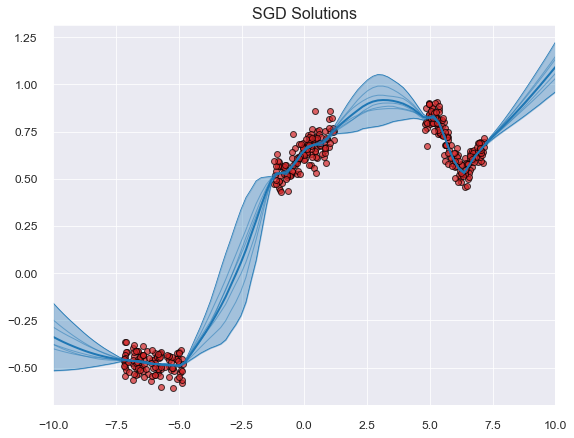

In [11]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))

trajectories = []
for i in range(5):
    model.load_state_dict(torch.load("ckpts/sgd_checkpoint" + str(i+1) + ".pt"))
    out = model(inp).detach().numpy().T
    trajectories.append(out)
trajectories = np.vstack(trajectories)
plot_predictive(data, trajectories, z, title="SGD Solutions")

Independently-trained SGD solutions are diverse far away from the data. In the following we aim to obtain similar behavior with local Bayesian model averaging within low-dimensional subspaces.

## Pre-Training SWAG Solutions and PCA Subspaces
We pre-train two different SWAG solutions. You can also skip this section and just load the provided checkpoints later.

In [12]:
wd = 0.
lr_init = 1e-2

for i in range(2):
    print("Training Model", i)
    swag_model = SWAG(model_cfg.base, subspace_type="pca", *model_cfg.args, **model_cfg.kwargs, 
                  subspace_kwargs={"max_rank": 10, "pca_rank": 10})
    model = model_cfg.base(*model_cfg.args, **model_cfg.kwargs)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_init, momentum=0.95, weight_decay=wd)
    
    train(model, loader, optimizer, criterion, lr_init, 3000, print_freq=1000, 
          swag=True, swag_model=swag_model, swag_start=2000, swag_freq=10, swag_lr=1e-2)

#     utils.save_checkpoint(
#          dir="ckpts",
#          epoch=3000,
#          name="swag_checkpoint"+str(i),
#          state_dict=swag_model.state_dict(),
#     )

Training Model 0
Epoch 0. LR: 0.01. Loss: 0.1735
Epoch 1000. LR: 0.01. Loss: 0.0013
Epoch 2000. LR: 0.01. Loss: 0.0013
Epoch 2999. LR: 0.01. Loss: 0.0014
Training Model 1
Epoch 0. LR: 0.01. Loss: 0.2012
Epoch 1000. LR: 0.01. Loss: 0.0013
Epoch 2000. LR: 0.01. Loss: 0.0013
Epoch 2999. LR: 0.01. Loss: 0.0014


Let's visualize one of our solutions.

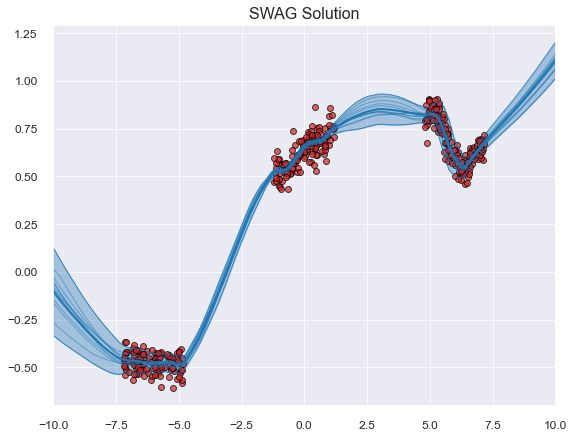

In [13]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))

swag_model = SWAG(model_cfg.base, subspace_type="pca", *model_cfg.args, **model_cfg.kwargs, 
                  subspace_kwargs={"max_rank": 10, "pca_rank": 10})
swag_model.load_state_dict(torch.load("ckpts/swag_checkpoint0-3000.pt")["state_dict"])

trajectories = []
for i in range(100):
    swag_model.sample(scale=10.)
    out = swag_model(inp)
    trajectories.append(out.detach().numpy().ravel())
    
trajectories = np.vstack(trajectories)
plot_predictive(data, trajectories, z, title="SWAG Solution")

## Pre-Training Curve Subspace

Note that for this to work you need to add the repo https://github.com/timgaripov/dnn-mode-connectivity to your Python path. You can skip this section as well and just load the provided checkpoints later.

We first load the two endpoints of the curve as SWA solutions.

In [16]:
# import curves 

swag_model = SWAG(model_cfg.base, subspace_type="pca", *model_cfg.args, **model_cfg.kwargs, 
                  subspace_kwargs={"max_rank": 10, "pca_rank": 10})

model1 = model_cfg.base(*model_cfg.args, **model_cfg.kwargs)
swag_model.load_state_dict(torch.load("ckpts/swag_checkpoint0-3000.pt")["state_dict"])
w_swa = swag_model.get_space()[0]
utils.set_weights(model1, w_swa)
    
model2 = model_cfg.base(*model_cfg.args, **model_cfg.kwargs)
swag_model.load_state_dict(torch.load("ckpts/swag_checkpoint1-3000.pt")["state_dict"])
w_swa = swag_model.get_space()[0]
utils.set_weights(model2, w_swa)

Initialize the curve model.

In [19]:
from subspace_inference import curves
architecture = model_cfg.curve
curve = curves.Bezier(3)
model = curves.CurveNet(curve, architecture, 3, fix_end=True, fix_start=True, 
                        architecture_kwargs=model_cfg.kwargs)
model.import_base_parameters(model1, 0)
model.import_base_parameters(model2, 2)
model.init_linear()

TypeError: __init__() missing 1 required positional argument: 'num_bends'

In [ ]:
wd = 0.
lr_init = 1e-2

optimizer = torch.optim.SGD(model.parameters(), lr=lr_init, momentum=0.95, weight_decay=wd)
train(model, loader, optimizer, criterion, lr_init, 6000, print_freq=1000)
# torch.save(model.state_dict(), "curve.pt")

Let's visualize the samples corresponding to different points on the curve.

In [ ]:
model.load_state_dict(torch.load("ckpts/curve.pt"))

z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))

trajectories = []
for t in np.linspace(0, 1, 20):
    out = model(inp, t)
    trajectories.append(out.detach().numpy().ravel())
    
trajectories = np.vstack(trajectories)

plot_predictive(data, trajectories, z, title="Solutions along the Curve")

We now save the parameters of the curve as a numpy array.

In [15]:
# W = []
# for i in range(3):
#     model.export_base_parameters(model1, i)
#     W.append(np.concatenate([param.data.numpy().reshape(-1) for param in model1.parameters()]))
# W = np.vstack(W)
# W[1, :] = 0.25*(W[0, :] + W[2, :]) + 0.5 * W[1, :]
# np.save("ckpts/curve_parameters.npy", W)

## Subspace Inference

Now we will showcase subspace inference with different inference methods and subspaces. We first define functions that load each of the 3 subspaces: _Random_, _PCA_ and _Curve_. The subspaces are constructed from the checkpoints we pre-trained above.

In [19]:
from subspace_inference.posteriors.proj_model import SubspaceModel
from subspace_inference.posteriors.ess import EllipticalSliceSampling
from subspace_inference.posteriors.vi_model import VIModel, ELBO
import math


def get_rand_space(seed=1):
    swag_model = SWAG(model_cfg.base, subspace_type="pca", *model_cfg.args, **model_cfg.kwargs, 
                  subspace_kwargs={"max_rank": 10, "pca_rank": 10})
    swag_model.load_state_dict(torch.load("ckpts/swag_checkpoint0-3000.pt")["state_dict"])
    mean, _, cov_factor = swag_model.get_space()
    torch.manual_seed(seed)
    cov_factor = torch.randn_like(cov_factor)
    cov_factor /= torch.norm(cov_factor, dim=1)[:, None]
    subspace = SubspaceModel(mean, cov_factor)
    return subspace

def get_pca_space():
    swag_model = SWAG(model_cfg.base, subspace_type="pca", *model_cfg.args, **model_cfg.kwargs, 
                  subspace_kwargs={"max_rank": 10, "pca_rank": 10})
    swag_model.load_state_dict(torch.load("ckpts/swag_checkpoint0-3000.pt")["state_dict"])
    mean, _, cov_factor = swag_model.get_space()
    subspace = SubspaceModel(mean, cov_factor)
    return subspace
    
def get_curve_space():
    
    w = np.load("ckpts/curve_parameters.npy")

    mean = np.mean(w, axis=0)
    u = w[2] - w[0]
    du = np.linalg.norm(u)

    v = w[1] - w[0]
    v -= u / du * np.sum(u / du * v)
    dv = np.linalg.norm(v)

    print(du, dv)
    u /= math.sqrt(3.0)
    v /= 1.5

    cov_factor = np.vstack((u[None, :], v[None, :]))
    subspace = SubspaceModel(torch.FloatTensor(mean), torch.FloatTensor(cov_factor))
    return subspace

Now, let's run ESS in each of the subspaces.

### ESS, Random Subspace

In [20]:
subspace = get_rand_space()
init_sigma = 1.
prior_sigma = 1.
criterion = losses.GaussianLikelihood(noise_var=.05)
temperature = .15

ess_model = EllipticalSliceSampling(
    base=model_cfg.base,
    subspace=subspace,
    var=None,
    loader=loader, 
    criterion=criterion, 
    num_samples=1000,
    use_cuda = False,
    *model_cfg.args,
    **model_cfg.kwargs
)
ess_model.fit(temperature=temperature, scale=prior_sigma**2);

We can now plot the predictive distribution.

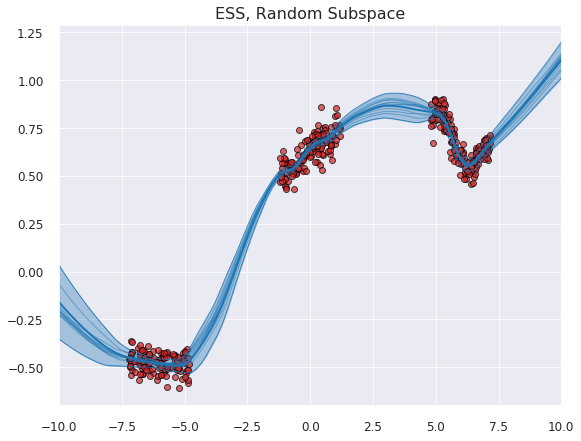

In [21]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))

trajectories = []
for i in range(100):
    ess_model.sample()
    out = ess_model(inp)
    trajectories.append(out.detach().numpy().ravel())

trajectories = np.vstack(trajectories)
plot_predictive(data, trajectories, z, title="ESS, Random Subspace")

Notice how uncertainty doesn't increase much between the data.

### ESS, PCA Subspace

In [22]:
subspace = get_pca_space()
init_sigma = 1.
prior_sigma = 5.
criterion = losses.GaussianLikelihood(noise_var=.05)
temperature = 1.5

ess_model = EllipticalSliceSampling(
    base=model_cfg.base,
    subspace=subspace,
    var=None,
    loader=loader, 
    criterion=criterion, 
    num_samples=1000,
    use_cuda = False,
    *model_cfg.args,
    **model_cfg.kwargs
)
ess_model.fit(temperature=temperature, scale=prior_sigma**2);

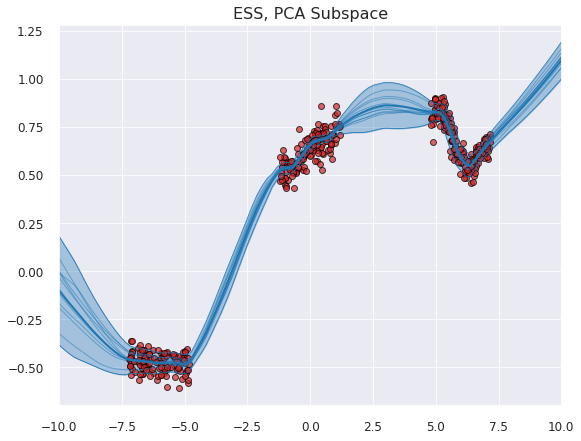

In [23]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))

trajectories = []
for i in range(100):
    ess_model.sample()
    out = ess_model(inp)
    trajectories.append(out.detach().numpy().ravel())

trajectories = np.vstack(trajectories)
plot_predictive(data, trajectories, z, title="ESS, PCA Subspace")

In the PCA subspace on the other hand the uncertainty does increase substantially between the middle and right clusters of data.

### ESS, Curve Subspace

In [44]:
subspace = get_curve_space()
prior_sigma = 1.
criterion = losses.GaussianLikelihood(noise_var=.05)
temperature = 0.75

ess_model = EllipticalSliceSampling(
    base=model_cfg.base,
    subspace=subspace,
    var=None,
    loader=loader, 
    criterion=criterion, 
    num_samples=1000,
    use_cuda = False,
    *model_cfg.args,
    **model_cfg.kwargs
)
ess_model.fit(temperature=temperature, scale=prior_sigma**2);

17.30122 7.6684074


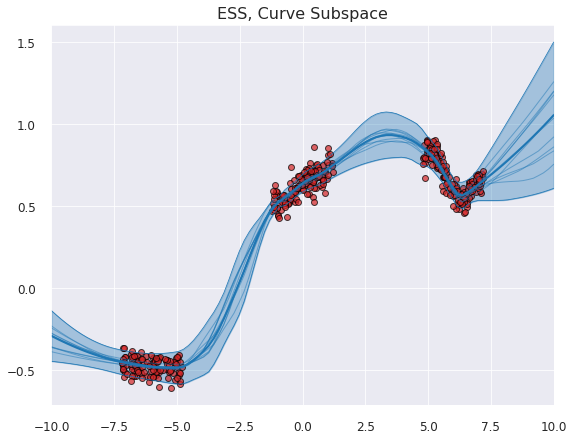

In [45]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))

trajectories = []
for i in range(1000):
    ess_model.sample()
    out = ess_model(inp)
    trajectories.append(out.detach().numpy().ravel())

trajectories = np.vstack(trajectories)
plot_predictive(data, trajectories, z, title="ESS, Curve Subspace")

Finally, in the richest curve subspace, uncertainty is low near the data, but gets high as we move away from the data.

## VI, PCA Subspace

We can also run other inference methods in the subspaces. For example, here is variational inference in the PCA subspace.

In [26]:
subspace = get_pca_space()
init_sigma = 1.
prior_sigma = 5.
criterion = losses.GaussianLikelihood(noise_var=.05)
temperature = 1.

vi_model = VIModel(
    subspace=subspace,
    init_inv_softplus_sigma=math.log(math.exp(init_sigma) - 1.0),
    prior_log_sigma=math.log(prior_sigma),
    base=model_cfg.base,
    *model_cfg.args,
    **model_cfg.kwargs
)

elbo = ELBO(criterion, len(loader.dataset), temperature=temperature)
optimizer = torch.optim.Adam([param for param in vi_model.parameters()], lr=.1)

for epoch in range(2000):
    train_res = utils.train_epoch(loader, vi_model, elbo, optimizer, regression=True, cuda=False)
    sigma = torch.nn.functional.softplus(vi_model.inv_softplus_sigma.detach().cpu())
    if epoch % 1000 == 0 or epoch == 1999:
        print(epoch, train_res)
    if epoch == 1000:
        utils.adjust_learning_rate(optimizer, 0.01)

0 {'stats': {'kl': 0.036303742323070765, 'nll': 0.025028734235092998}, 'accuracy': None, 'loss': 0.061332476790994406}
1000 {'stats': {'kl': 0.01581537676975131, 'nll': 0.027013688813894987}, 'accuracy': None, 'loss': 0.0428290655836463}
1999 {'stats': {'kl': 0.014895313885062933, 'nll': 0.0270280996337533}, 'accuracy': None, 'loss': 0.04192341445013881}


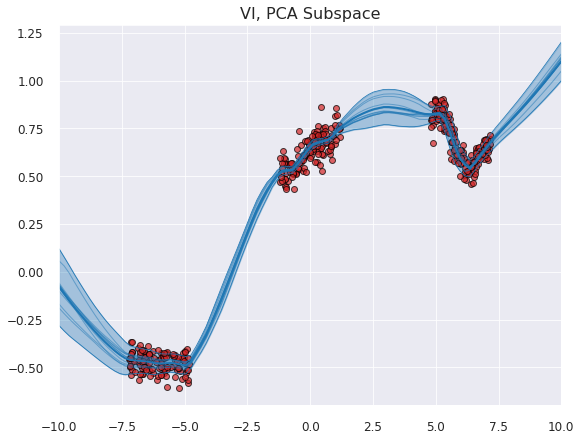

In [27]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))

trajectories = []
for i in range(100):
    out = vi_model(inp)
    trajectories.append(out.detach().numpy().ravel())

trajectories = np.vstack(trajectories)
plot_predictive(data, trajectories, z, title="VI, PCA Subspace")

## NUTS, Curve Subspace

And here we apply the no-u-turn-sampler (NUTS) in the curve subspace.

In [28]:
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import HMC, MCMC, NUTS

from subspace_inference.posteriors.pyro import PyroModel
from subspace_inference.utils import extract_parameters, set_weights

In [29]:
subspace = get_curve_space()
prior_sigma = 1.
# criterion = losses.GaussianLikelihood(noise_var=.05)
temperature = 0.5

pyro_model = PyroModel(
    base=model_cfg.base,
    subspace=subspace,
    prior_log_sigma=math.log(prior_sigma), 
    likelihood_given_outputs=lambda x: dist.Normal(x, np.sqrt(.05 / temperature)),
    *model_cfg.args,
    **model_cfg.kwargs
)

17.30122 7.6684074


In [30]:
nuts_kernel = NUTS(pyro_model.model, step_size=1.)

In [31]:
x_, y_ = loader.dataset.tensors
mcmc_run = MCMC(nuts_kernel, num_samples=200, warmup_steps=100).run(x_, y_)
samples = torch.cat(list(mcmc_run.marginal(sites="t").support(flatten=True).values()), dim=-1)
# samples

Sample: 100%|██████████| 300/300 [00:40<00:00,  6.45it/s, step size=4.96e-02, acc. rate=0.887]


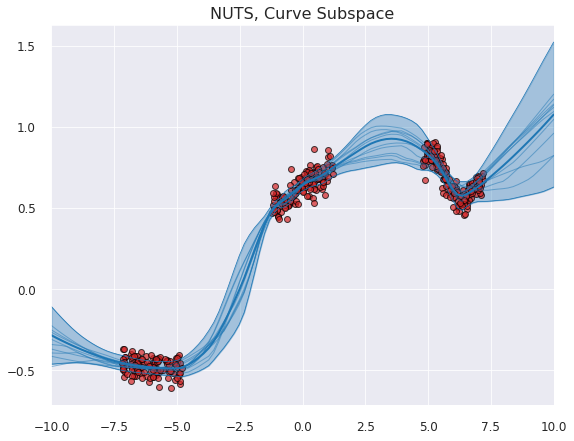

In [32]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))

trajectories = []
for i in range(200):
    pyro_model.t.set_(samples[i, :])
    out = pyro_model(inp)
    trajectories.append(out.detach().numpy().ravel())

trajectories = np.vstack(trajectories)
plot_predictive(data, trajectories, z, title="NUTS, Curve Subspace")

We can verify that samples indeed concentrate around a curve in the subspace by plotting them.

Text(0.5, 1.0, 'Samples in the subspace')

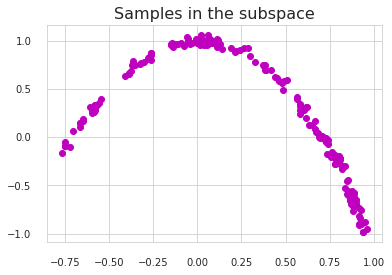

In [33]:
sns.set_style("whitegrid")
plt.plot(samples.numpy()[:, 0], samples.numpy()[:, 1], "mo")
plt.title("Samples in the subspace", fontsize=16)